https://github.com/RodolfoLSS/stock-prediction-pytorch/blob/master/stock-prediction-pytorch.ipynb

In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import imageio

from talib.abstract import CCI, DX, MACD, RSI

In [2]:
from cpl.data.processor_binance import BinanceProcessor

In [3]:
ticker_list = ["BTCUSDT","ETHUSDT"]
start_date = "2021-12-01"
end_date = "2021-12-15"
time_interval = "1m"
tech_inds = ['rsi','macd']

In [4]:
p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)
df = p.add_technical_indicator(df, tech_inds)

Succesfully add technical indicators


In [5]:
btc_df = df[df.tic=="BTCUSDT"][["time","open","high","low","close","volume","rsi","macd"]]
btc_df.head()

,time,open,high,low,close,volume,rsi,macd
1,2021-12-01 00:01:00,56782.00,56813.51,56740.00,56755.50,39.00328,0.0,-0.594551
2,2021-12-01 00:02:00,56755.49,56755.50,56712.21,56720.84,23.64537,0.0,-1.832381
3,2021-12-01 00:03:00,56720.83,56749.73,56712.22,56720.01,17.43134,0.0,-2.380430
4,2021-12-01 00:04:00,56717.01,56727.62,56700.00,56714.45,19.49503,0.0,-2.849363
5,2021-12-01 00:05:00,56714.46,56718.65,56671.37,56691.50,45.32811,0.0,-4.059052


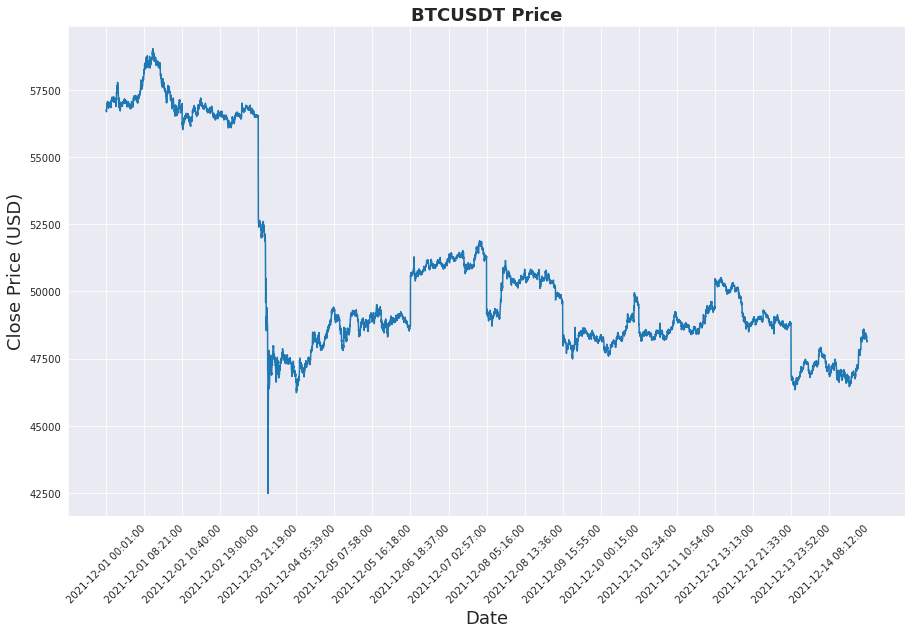

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(btc_df[['close']])
plt.xticks(range(0,btc_df.shape[0],500),btc_df['time'].loc[::500],rotation=45)
plt.title("BTCUSDT Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [8]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [9]:
btc_df.shape

(9998, 8)

In [10]:
price = btc_df[['close']]
price.head()

,close
1,56755.50
2,56720.84
3,56720.01
4,56714.45
5,56691.50


In [29]:
# normalizing the price data?
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['close'] = scaler.fit_transform(price['close'].values.reshape(-1,1))

<ipython-input-29-71d2b02a7efd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['close'] = scaler.fit_transform(price['close'].values.reshape(-1,1))


In [30]:
price.head()

,close
1,0.724271
2,0.720084
3,0.719983
4,0.719312
5,0.716539


In [31]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (7982, 19, 1)
y_train.shape =  (7982, 1)
x_test.shape =  (1996, 19, 1)
y_test.shape =  (1996, 1)


In [32]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

### making the network (LSTM in this example)

In [33]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 50

In [34]:
import torch.nn as nn

In [35]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [36]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

### Training

In [37]:
y_pred = model(x_train)

In [38]:
y_pred

tensor([[0.1479],
        [0.1479],
        [0.1479],
        ...,
        [0.1401],
        [0.1401],
        [0.1402]], grad_fn=<AddmmBackward0>)

In [39]:
y_train_lstm

tensor([[ 0.7595],
        [ 0.7623],
        [ 0.7538],
        ...,
        [-0.1683],
        [-0.0344],
        [-0.0352]])

In [40]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.19205842912197113
Epoch  1 MSE:  0.17377969622612
Epoch  2 MSE:  0.15874071419239044
Epoch  3 MSE:  0.12448037415742874
Epoch  4 MSE:  0.07681524008512497
Epoch  5 MSE:  0.014344925992190838
Epoch  6 MSE:  0.07063473761081696
Epoch  7 MSE:  0.14693725109100342
Epoch  8 MSE:  0.030263803899288177
Epoch  9 MSE:  0.004825407173484564
Epoch  10 MSE:  0.020552080124616623
Epoch  11 MSE:  0.032516807317733765
Epoch  12 MSE:  0.03664972633123398
Epoch  13 MSE:  0.036749228835105896
Epoch  14 MSE:  0.034093212336301804
Epoch  15 MSE:  0.028634076938033104
Epoch  16 MSE:  0.02079632692039013
Epoch  17 MSE:  0.012543456628918648
Epoch  18 MSE:  0.007496202830225229
Epoch  19 MSE:  0.008505783975124359
Epoch  20 MSE:  0.0133726941421628
Epoch  21 MSE:  0.016025148332118988
Epoch  22 MSE:  0.014089801348745823
Epoch  23 MSE:  0.009919615462422371
Epoch  24 MSE:  0.0062342616729438305
Epoch  25 MSE:  0.004107738845050335
Epoch  26 MSE:  0.003475344739854336
Epoch  27 MSE:  0.003905

In [41]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

### Plotting Results

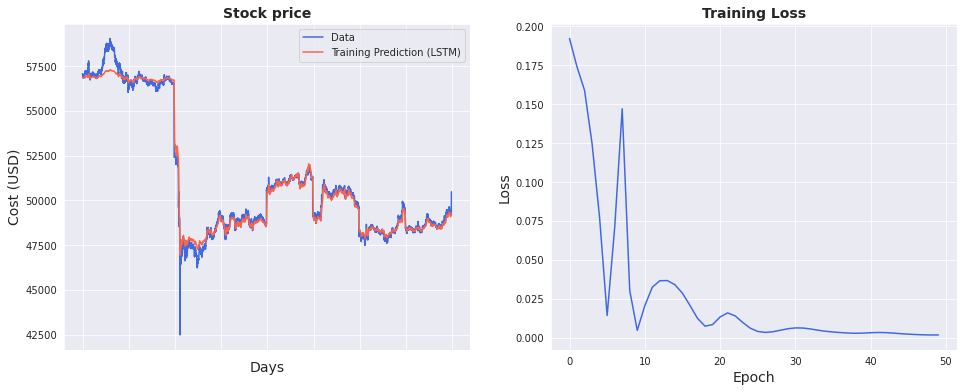

In [42]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [43]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 357.08 RMSE
Test Score: 426.12 RMSE


The RMSE vtells us the average deviation between the predicted price made by the model and the actual price <br>
The R^2 is the proportion of the variation in the dependent variable that is predictable from the independent variable
R^2 = 1- RSS/TSS, where RSS = sum(y_i - f(x_i))^2; TSS - sum(y_i - y_bar)^2

In [76]:
def calc_r2(y_actual, y_pred):
    rss = sum( (y_actual - y_pred)**2 )
    print("rss", rss)
    y_bar = np.mean(y_actual)
    tss = sum( (y_actual - y_bar)**2 )
    print("tss", tss)
    r2 = 1-(rss/tss)
    print("r2:", r2)

In [77]:
calc_r2(y_train[:,0], y_train_pred[:,0])

rss 1017772874.6506348
tss 101871443594.83754
r2: 0.9900092426421431
